# Final Report and Summary of Analysis: Improving Timely Diagnoses in Medical Imaging

#### CONTENTS

    I. Purpose
    II. Data and Context
    III. Model Creation
    IV. Evaluate Results
    V. Recommendations
    VI. Next Steps

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

import tensorflow as tf
print(tf.__version__)


from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.functions as fn

plt.style.use('fivethirtyeight')

In [2]:
#Depending on the version of tensorflow and keras on your os, you may need to run this 
#cell instead of the above cell for the necessary imports
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import glob
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
#Transfer Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import src.functions as fn
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## I. Purpose

Applications of technology in the field of medicine have come in many forms, including equipment and procedural advancements. With the goal of improving the quality of health and care that is delivered to patients, the purpose of this notebook is to explore the use of Neural Networks in medical imaging to aid in the timely diagnoses to those who need it most. 

#### Goal:

Build a tool that uses a Convolutional Neural Network (CNN) to assist in diagnosing patients with Pneumonia. This Neural Network will reliably identify patients with pneumonia so radiologists and doctors can prioritize those patients for quicker review, diagnoses, and treatment.

## II. Data and Context

Our data comes from Guangzhou Women and Children’s Medical Center. The original data set can be found [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).
- Reviewed by two physicians to confirm the accuracy of the diagnoses. 
- Includes bacterial and viral pneumonia.
- Uses anterior and posterior ex-ray views.

### Data Cleaning

While exploring the image data set, we discovered that a number of images in the pneumonia data set had visible medical equipment, while very few of the healthy lung images had such medical equipment. 

Here is a pneumonic lung x-ray with what appears to be an IV in the upper right corner of the image, and an electrode on the upper left, along with some type of tubing to the left of the heart and across the lower ribcage.

<img src="../../references/person109_bacteria_519.jpeg" alt="drawing" width="400"/> 

Here is another x-ray of a pneumonic lung, this time with no visible medical euipment. We would consider this a clean image.

<img src="../../references/person3_virus_15.jpeg" alt="drawing" width="400"/>

#### Why does this matter?
We want to make sure that our model is examining lungs for signs of pneumonia in a similar manner to an actual physician or radiologist. With this medical equipment being so prevelant in the pneumonic lung images, we may inadvertantly train our model to interpret medical equipment as a sign of pneuomonia.

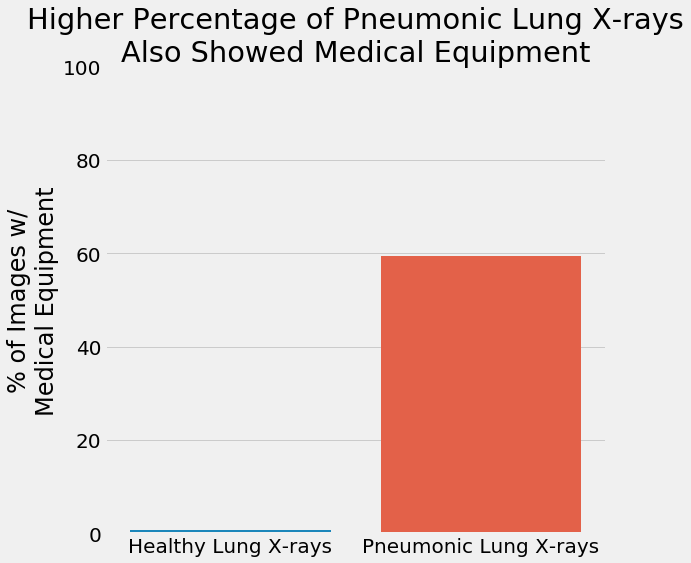

In [11]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1, figsize=(8,8))
labels = 'Clean X-rays', 'X-rays with Visible\nMedical Equipment'
healthy = 9/(1132+9)*100
ill = 2105/(1436+2105)*100
explode = (0, 0.01)

sns.barplot(['Healthy Lung X-rays', 'Pneumonic Lung X-rays'], [healthy, ill])
ax.set_ylim(0,100)
ax.set_ylabel('% of Images w/\nMedical Equipment')
ax.set_title('Higher Percentage of Pneumonic Lung X-rays\nAlso Showed Medical Equipment');

#### Solution:
We went through each image in the training data and manually deleted all x-rays that appeared to have medical equipment in them. This cut out about 1500 images unfortunately, but we determined this was worth it in order to prevent a model from learning incorrectly.

## III. Model Creation

#### Summary of Workflow

    1. Build First Simple Model
     - Evaluate
    2. Build additional models using a variety of methods and architechtures
     - Optimize for Recall and Accuracy
     - Review results and explore new approaches for feature engineering
     - Repeat steps 3 and 4
     - Choose the best model 

### 1. Build First Simple Model

In [2]:
train_data, val_data, test_data = fn.load_data_generators()

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Model Parameters:
- Layers:
 - Flatten layer
   - Note on input shape: The data generators for this model provided images that were greyscale at dimensions 100x100
 - Dense layer with 85 nodes and ReLU activation
 - Output layer
- Optimizer: Adam
- Loss: binary crossentropy

In [3]:
model = Sequential()
model.add(Flatten(input_shape=(100,100,1)))
model.add(Dense(units=85, 
                activation='relu'))
model.add(Dense(units=1, 
                activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

### Fit model
#### This cell may take more than 10 minutes to run
- Trained for 10 epochs
- Number of steps is set equal to the length of the data generator which means it will run through every image at each epoch.

In [4]:
history = model.fit(train_data, 
                    epochs=10, 
                    validation_data=(val_data), 
                    steps_per_epoch=len(train_data), 
                    validation_steps=len(val_data))

Epoch 1/10
81/81 [==============================] - 54s 662ms/step - loss: 0.9850 - accuracy: 0.6351 - precision: 0.6430 - recall: 0.7813 - val_loss: 0.5532 - val_accuracy: 0.7873 - val_precision: 0.7922 - val_recall: 0.8918
Epoch 2/10
81/81 [==============================] - 51s 625ms/step - loss: 0.5194 - accuracy: 0.7640 - precision: 0.7470 - recall: 0.8740 - val_loss: 0.4885 - val_accuracy: 0.8091 - val_precision: 0.8937 - val_recall: 0.7865
Epoch 3/10
81/81 [==============================] - 48s 596ms/step - loss: 0.4450 - accuracy: 0.8053 - precision: 0.7951 - recall: 0.8781 - val_loss: 0.4188 - val_accuracy: 0.8364 - val_precision: 0.8795 - val_recall: 0.8538
Epoch 4/10
81/81 [==============================] - 45s 552ms/step - loss: 0.4062 - accuracy: 0.8220 - precision: 0.8266 - recall: 0.8628 - val_loss: 0.3583 - val_accuracy: 0.8527 - val_precision: 0.8896 - val_recall: 0.8713
Epoch 5/10
81/81 [==============================] - 44s 548ms/step - loss: 0.3967 - accuracy: 0.8252

## Evaluation on holdout

In [5]:
acc = model.evaluate(test_data, steps=len(test_data), verbose=1)
list(zip(model.metrics_names, acc))

20/20 [==============================] - 5s 266ms/step - loss: 0.3890 - accuracy: 0.8157 - precision: 0.8022 - recall: 0.9359


[('loss', 0.3890226185321808),
 ('accuracy', 0.8157051205635071),
 ('precision', 0.8021978139877319),
 ('recall', 0.9358974099159241)]

### 2. Building Additional Models 

#### Note on the input shape:
- We needed to update the data generators to remove the greyscale color mode for transfer learning
- We also increased the shear and zoom range by .1

In [3]:
transfer_train_data, transfer_val_data, transfer_test_data = fn.load_datagen_report()

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
len(transfer_test_data)

20

#### The model iterations below used the pre-trained models:
 1. **MobileNet-V2**
 2. **Inception-V3**
 3. **Inception-ResNet-V2**
     - Model Parameters
         - Layers:
             - Pre-trained model layers (not including top)
             - GlobalAveragePooling2D layer to minimize overfitting by reducing parameters
             - Dense layer with 50 nodes and relu activation
             - Output layer with 1 node and sigmoid activation
         - Optimizer:
             - Adam
         - Loss:
             - Binary CrossEntropy
         - Fit Parameters:
             - 10 epochs

In [7]:
METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]
input_shape = Input(shape=(100,100,3))

#### *MobileNetV2*

In [24]:
base_mobilenet = MobileNetV2(input_tensor=input_shape,
                            include_top=False,
                            weights='imagenet')
base_mobilenet.trainable=False

mobilenet = Sequential([base_mobilenet,
                       tf.keras.layers.GlobalAveragePooling2D(),
                       tf.keras.layers.Dense(50, activation='relu'),
                       tf.keras.layers.Dense(1, activation='sigmoid')])

mobilenet.compile(optimizer='Adam',
                 loss='binary_crossentropy',
                 metrics=METRICS)
image_size=100
batch_size=32
epochs = 10

steps_per_epoch = transfer_train_data.n // batch_size

mobilenet_history = mobilenet.fit(transfer_train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/10
80/80 [==============================] - 20s 249ms/step - loss: 0.4794 - accuracy: 0.7744 - precision: 0.8071 - recall: 0.8438 - val_loss: 0.3288 - val_accuracy: 0.8618 - val_precision: 0.9890 - val_recall: 0.7865
Epoch 2/10
80/80 [==============================] - 21s 258ms/step - loss: 0.3360 - accuracy: 0.8557 - precision: 0.8741 - recall: 0.8667 - val_loss: 0.1885 - val_accuracy: 0.9218 - val_precision: 0.9776 - val_recall: 0.8947
Epoch 3/10
80/80 [==============================] - 21s 257ms/step - loss: 0.3069 - accuracy: 0.8691 - precision: 0.8829 - recall: 0.8829 - val_loss: 0.2031 - val_accuracy: 0.9182 - val_precision: 0.9459 - val_recall: 0.9211
Epoch 4/10
80/80 [==============================] - 20s 249ms/step - loss: 0.2796 - accuracy: 0.8872 - precision: 0.9031 - recall: 0.8942 - val_loss: 0.1956 - val_accuracy: 0.9345 - val_precision: 0.9608 - val_recall: 0.9327
Epoch 5/10
80/80 [==============================] - 20s 252ms/step - loss: 0.2706 - accuracy: 0.8845

### Evaluation on holdout

In [30]:
acc = mobilenet.evaluate(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(mobilenet.metrics_names, acc))

14/14 [==============================] - 5s 337ms/step - loss: 0.6721 - accuracy: 0.7799 - precision: 0.6906 - recall: 0.9385


[('loss', 0.6721115112304688),
 ('accuracy', 0.7798594832420349),
 ('precision', 0.6905660629272461),
 ('recall', 0.9384615421295166)]

#### This model performed worse than our baseline

#### *InceptionV3*

In [10]:
input_shape = Input(shape=(100,100,3))

base_model_inception3 = InceptionV3(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model_inception3.trainable=False

inception3 = Sequential([base_model_inception3,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

inception3.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 10

steps_per_epoch = transfer_train_data.n // batch_size

inception3_history = inception3.fit(transfer_train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/10
80/80 [==============================] - 16s 202ms/step - loss: 0.4730 - accuracy: 0.7784 - precision: 0.7866 - recall: 0.8257 - val_loss: 0.3261 - val_accuracy: 0.8527 - val_precision: 0.9307 - val_recall: 0.8246
Epoch 2/10
80/80 [==============================] - 16s 205ms/step - loss: 0.4005 - accuracy: 0.8202 - precision: 0.8314 - recall: 0.8513 - val_loss: 0.2778 - val_accuracy: 0.8709 - val_precision: 0.8928 - val_recall: 0.9006
Epoch 3/10
80/80 [==============================] - 16s 199ms/step - loss: 0.3644 - accuracy: 0.8324 - precision: 0.8455 - recall: 0.8568 - val_loss: 0.2670 - val_accuracy: 0.8891 - val_precision: 0.9096 - val_recall: 0.9123
Epoch 4/10
80/80 [==============================] - 16s 203ms/step - loss: 0.3658 - accuracy: 0.8364 - precision: 0.8552 - recall: 0.8522 - val_loss: 0.2561 - val_accuracy: 0.8818 - val_precision: 0.9369 - val_recall: 0.8684
Epoch 5/10
80/80 [==============================] - 16s 197ms/step - loss: 0.3511 - accuracy: 0.8450

In [11]:
acc = inception3.evaluate(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception3.metrics_names, acc))

14/14 [==============================] - 4s 272ms/step - loss: 0.4365 - accuracy: 0.8080 - precision: 0.7511 - recall: 0.8667


[('loss', 0.4365231394767761),
 ('accuracy', 0.8079625368118286),
 ('precision', 0.7511110901832581),
 ('recall', 0.8666666746139526)]

#### The InceptionV3 performed better than MobileNetV2, but still worse than our baseline

#### *InceptionResNetV2*

In [8]:
input_shape = Input(shape=(100,100,3))

base_model_inception_res = InceptionResNetV2(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model_inception_res.trainable=False

inception_resnet2 = Sequential([base_model_inception_res,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

image_size=100
batch_size=32
epochs = 10

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/10
80/80 [==============================] - 23s 283ms/step - loss: 0.5074 - accuracy: 0.7630 - precision: 0.7835 - recall: 0.7962 - val_loss: 0.2497 - val_accuracy: 0.9109 - val_precision: 0.9347 - val_recall: 0.9211
Epoch 2/10
80/80 [==============================] - 20s 252ms/step - loss: 0.4052 - accuracy: 0.8285 - precision: 0.8408 - recall: 0.8556 - val_loss: 0.2052 - val_accuracy: 0.9236 - val_precision: 0.9438 - val_recall: 0.9327
Epoch 3/10
80/80 [==============================] - 20s 252ms/step - loss: 0.3687 - accuracy: 0.8391 - precision: 0.8556 - recall: 0.8568 - val_loss: 0.1937 - val_accuracy: 0.9255 - val_precision: 0.9362 - val_recall: 0.9444
Epoch 4/10
80/80 [==============================] - 21s 257ms/step - loss: 0.3598 - accuracy: 0.8360 - precision: 0.8459 - recall: 0.8638 - val_loss: 0.2439 - val_accuracy: 0.9000 - val_precision: 0.9799 - val_recall: 0.8567
Epoch 5/10
80/80 [==============================] - 21s 257ms/step - loss: 0.3568 - accuracy: 0.8517

### Evaluation on holdout

In [9]:
acc = inception_resnet2.evaluate(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

20/20 [==============================] - 6s 324ms/step - loss: 0.3377 - accuracy: 0.8814 - precision: 0.8873 - recall: 0.9282


[('loss', 0.33772945404052734),
 ('accuracy', 0.8814102411270142),
 ('precision', 0.8872548937797546),
 ('recall', 0.928205132484436)]

#### This pre-trained model performed the best out of the three, we chose to move forward with fine-tuning.

#### For the final model we added/changed:
- class weights- NORMAL : 1.32 | PNEUMONIA : .80
- training layers beginning with 600
- 100 nodes in the dense layer
- 25 epochs
- 70 steps per epoch


In [10]:
tr_train_files = glob.glob('../../data/chest_xray/val/NORMAL/*'),  glob.glob('../../data/chest_xray/val/PNEUMONIA/*')
tr_val_files = glob.glob('../../data/chest_xray/val/NORMAL/*'),  glob.glob('../../data/chest_xray/val/PNEUMONIA/*')
class_weight = fn.get_class_weight(tr_train_files, tr_val_files)

{0: 1.3221153846153846, 1: 0.804093567251462}


In [11]:
base_model_inception_res.trainable = True
print('Number of layers in the base model: ', len(base_model_inception_res.layers))

fine_tune = 600
for layer in base_model_inception_res.layers[: fine_tune]:
    layer.trainable = False

Number of layers in the base model:  780


In [47]:
inception_resnet2 = Sequential([base_model_inception_res,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(100, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 25
batch_size=32

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/25
80/80 [==============================] - 40s 503ms/step - loss: 0.0719 - accuracy: 0.9712 - precision: 0.9620 - recall: 0.9668 - val_loss: 0.1948 - val_accuracy: 0.9436 - val_precision: 0.9844 - val_recall: 0.9240
Epoch 2/25
80/80 [==============================] - 39s 488ms/step - loss: 0.0724 - accuracy: 0.9736 - precision: 0.9870 - recall: 0.9654 - val_loss: 2.3266 - val_accuracy: 0.9109 - val_precision: 0.9900 - val_recall: 0.8655
Epoch 3/25
80/80 [==============================] - 39s 491ms/step - loss: 0.0527 - accuracy: 0.9799 - precision: 0.9878 - recall: 0.9760 - val_loss: 0.2295 - val_accuracy: 0.9345 - val_precision: 0.9842 - val_recall: 0.9094
Epoch 4/25
80/80 [==============================] - 40s 504ms/step - loss: 0.0524 - accuracy: 0.9811 - precision: 0.9838 - recall: 0.9824 - val_loss: 0.3591 - val_accuracy: 0.9455 - val_precision: 0.9756 - val_recall: 0.9357
Epoch 5/25
80/80 [==============================] - 41s 509ms/step - loss: 0.0532 - accuracy: 0.9838

### Validation on holdout

20/20 [==============================] - 6s 322ms/step - loss: 0.2511 - accuracy: 0.9263 - precision: 0.9135 - recall: 0.9744


[('loss', 0.25112226605415344),
 ('accuracy', 0.9262820482254028),
 ('precision', 0.9134615659713745),
 ('recall', 0.9743589758872986)]

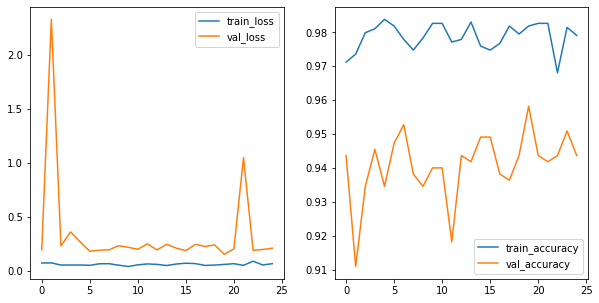

In [48]:
fn.plot_acc_loss(inception_resnet2, transfer_test_data, inception_resnet2_history)

## IV. Final Results

Our final model achieved a recall score of 97%, indicating that out of all x-rays showing some form of Pneumonia, our model successfully flagged 97 percent of them as having Pneumonia. This was a great improvement from our baseline model. Below is a plot of the ROC-AUC curves for both models, the final model shows to have 10% more area under the curve than the baseline model. The greater the area under the curve, the better the model is at distinguishing Pneunomia from Normal chest x-rays.

<img align="center" width="600" height="600" src="../../reports/figures/roc-auc.png"> 

## V. Recommendations

- Implement AI Image Recognition in radiology departments to:
    - Help aid radiologists in vaidation of initial screenings
    - Help aid in inpatient triage.
    - Help aid in classifying the form of Pneumonia the patent has (Viral or Bacterial)
    - Help aid in classifying the extent or severity of the Pneumonia
- When possible, remove hospital equipment from the patient (objects in the x-ray that the model might misinterpret as a form of Pneumonia)

## VI. Next Steps

- Train the model to classify Pneumonia type (Viral or Bacterial)
- Train time-series model on x-rays over a specific window of time to predict future severity or treatment options
- Train the model to detect other ailments shown in x-rays
- Develop a Web Applications for healthcare institutions that may not have have the necessary resources in screening for Pneumonia with an interface to upload and diagnose patient x-rays